In [ ]:
"""
credits to 
1. https://www.kaggle.com/pankajj/fashion-mnist-with-pytorch-93-accuracy
2. https://medium.com/@attyuttam/generative-adversarial-networks-using-pytorch-3ad31cc61ac8
3. https://colab.research.google.com/drive/1ExKu5QxKxbeO7QnVGQx6nzFaGxz0FDP3?usp=sharing#scrollTo=nqKLmvRJVnc3
"""
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image
from IPython.core.display import HTML 
from tqdm import tqdm
import imageio

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision.utils import save_image, make_grid

# helper functions
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)
outputs_dir = 'outputs'
models_dir = 'models'
for dirpath in [outputs_dir, models_dir]:
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')        

In [2]:
mnist = FashionMNIST(root='./db', train=True, download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))
batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle=False)

# Visualize the datasets

labels:  Ankle Boot, T-shirt/Top, T-shirt/Top, Dress, T-shirt/Top, Pullover, Sneaker, Pullover, Sandal, Sandal, 

T-shirt/Top, Ankle Boot, Sandal, Sandal, Sneaker, Ankle Boot, Trouser, T-shirt/Top, Shirt, Coat, 

Dress, Trouser, Coat, Bag, Coat, Dress, T-shirt/Top, Pullover, Coat, Coat, 

Sandal, Dress, Shirt, Shirt, T-shirt/Top, Bag, Sandal, Pullover, Trouser, Shirt, 

Shirt, Sneaker, Ankle Boot, Sandal, Ankle Boot, Pullover, Sneaker, Dress, T-shirt/Top, Dress, 

Dress, Dress, Sneaker, Pullover, Pullover, Shirt, Shirt, Bag, Dress, Dress, 

Sandal, T-shirt/Top, Sandal, Sandal, T-shirt/Top, Pullover, T-shirt/Top, T-shirt/Top, Coat, Trouser, 

Dress, Trouser, Shirt, Dress, Trouser, Coat, Coat, Shirt, Trouser, Ankle Boot, 

Trouser, Dress, Sandal, Sneaker, Ankle Boot, Sneaker, Trouser, Sneaker, Ankle Boot, Ankle Boot, 

Ankle Boot, Dress, Pullover, Ankle Boot, Dress, Shirt, Coat, Trouser, Trouser, Bag, 



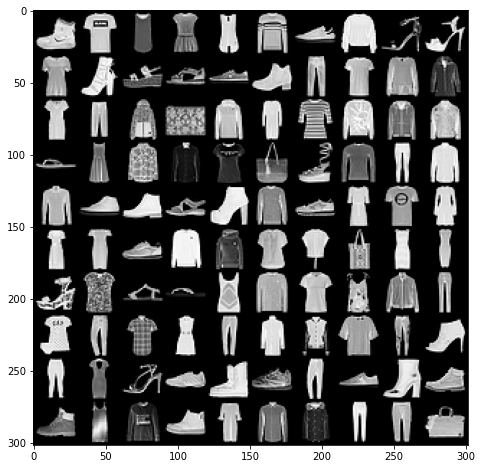

In [3]:
batch = next(iter(data_loader))
images, labels = batch
original_images = [denorm(img) for img in images]
grid = torchvision.utils.make_grid(original_images, nrow=10)
plt.figure(figsize=(8,8))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(output_label(label), end=", ")
    if (i+1) % 10 == 0:
        print("\n")

# Create the generator and discriminator 

1. The **generator** constructs a fake image from a random vector.
2. The **discriminator** is a simple classifier that tries to distinguish between fake and real images.

In [4]:
latent_size = 64
image_size = 784
hidden_size = 256

G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [5]:
Image(url= "https://miro.medium.com/max/2050/1*ypsvQH7kvtI2BhzR2eT_Sw.png", width=512, height=256)

**Why Tanh?**
```
The ReLU activation (Nair & Hinton, 2010) is used in the generator with the exception of the output layer which uses the Tanh function. We observed that using a bounded activation allowed the model to learn more quickly to saturate and cover the color space of the training distribution. Within the discriminator we found the leaky rectified activation (Maas et al., 2013) (Xu et al., 2015) to work well, especially for higher resolution modeling.
```

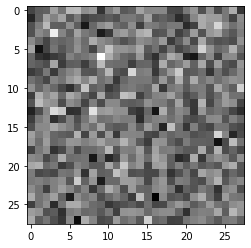

In [6]:
fake_img = G(torch.randn(1, latent_size))
fake_img_original_scale = denorm(fake_img.reshape((-1, 28,28)).detach())
plt.imshow(fake_img_original_scale[0], cmap='gray');

In [7]:
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [8]:
D(fake_img), D(mnist[0][0].reshape((1, 784)))

(tensor([[0.4990]], grad_fn=<SigmoidBackward>),
 tensor([[0.5040]], grad_fn=<SigmoidBackward>))

# Train the GAN

## train the discriminator

In [9]:
D.to(device)
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
        
    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs
    
    # Combine losses
    d_loss = d_loss_real + d_loss_fake

    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()
    
    return d_loss, real_score, fake_score

## train the generator

In [17]:
G.to(device)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

Saving fake_images-0000.png


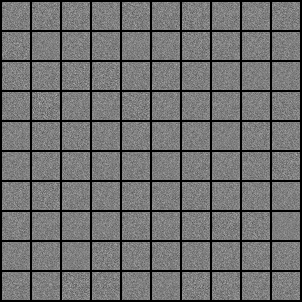

In [18]:
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)
    
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break
   
Image(os.path.join(sample_dir, 'real_images.png'))

# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

## Let's rock-and-roll

In [19]:
criterion = nn.BCELoss(); num_epochs = 300
data_loader = DataLoader(mnist, batch_size, shuffle=True)
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

In [20]:
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images(epoch+1)
    if epoch in [100, 200]:
        torch.save(G.state_dict(), f'models/{epoch}_generator.pth')
        torch.save(D.state_dict(), f'models/{epoch}_discriminator.pth')
print('DONE TRAINING')
torch.save(G.state_dict(), 'models/generator.pth')
torch.save(D.state_dict(), 'models/discriminator.pth')

Epoch [0/300], Step [200/600], d_loss: 0.0941, g_loss: 4.1542, D(x): 0.97, D(G(z)): 0.05
Epoch [0/300], Step [400/600], d_loss: 0.1665, g_loss: 4.6884, D(x): 0.96, D(G(z)): 0.07
Epoch [0/300], Step [600/600], d_loss: 0.0291, g_loss: 5.1907, D(x): 0.99, D(G(z)): 0.01
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.0573, g_loss: 4.0757, D(x): 1.00, D(G(z)): 0.05
Epoch [1/300], Step [400/600], d_loss: 0.1205, g_loss: 3.9101, D(x): 0.98, D(G(z)): 0.04
Epoch [1/300], Step [600/600], d_loss: 0.0365, g_loss: 5.4383, D(x): 0.99, D(G(z)): 0.02
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.0062, g_loss: 6.5973, D(x): 1.00, D(G(z)): 0.01
Epoch [2/300], Step [400/600], d_loss: 0.0106, g_loss: 6.7361, D(x): 1.00, D(G(z)): 0.01
Epoch [2/300], Step [600/600], d_loss: 0.0394, g_loss: 7.3483, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.1963, g_loss: 5.3755, D(x): 0.96, D(G(z)): 0.02
Epoch [3/300], Step [400/6

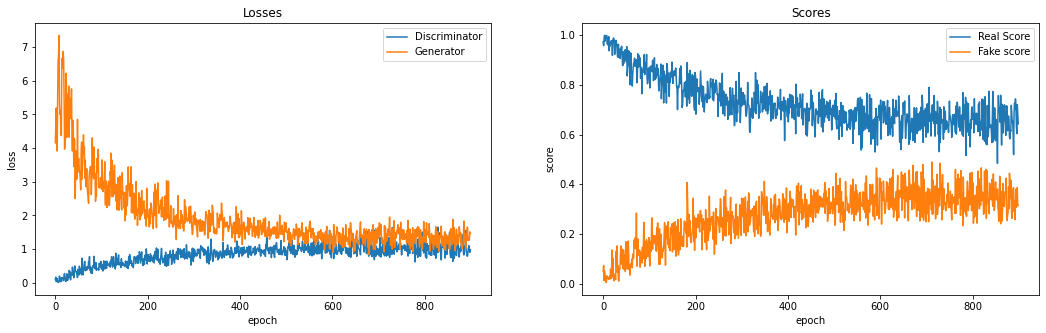

In [33]:
fig, axes = plt.subplots(1,2, figsize=(18,5))
axes[0].plot(d_losses, '-')
axes[0].plot(g_losses, '-')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss')
axes[0].legend(['Discriminator', 'Generator'])
axes[0].set_title('Losses');
axes[1].plot(real_scores, '-')
axes[1].plot(fake_scores, '-')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('score')
axes[1].legend(['Real Score', 'Fake score'])
axes[1].set_title('Scores');
plt.savefig('outputs/loss-score.png')

In [40]:
np.save('outputs/d_losses.npy', d_losses)
np.save('outputs/g_losses.npy', g_losses)
np.save('outputs/real_scores.npy', real_scores)
np.save('outputs/fake_scores.npy', fake_scores)

In [44]:
import cv2
import os
from IPython.display import FileLink

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.avi')

/share/ceph/hawk/cse498_s2021_053121/yud319/ReproducePaper/GAN_tutorial/gans_training.avi